In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_breast_cancer

# Load Data

In [2]:
cancer_dataset = load_breast_cancer()
assert isinstance(cancer_dataset, dict)
print(cancer_dataset.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
# Description of the dataset
print(cancer_dataset['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [4]:
cancer = pd.DataFrame(cancer_dataset['data'], columns=cancer_dataset['feature_names'])  # pandas dataframe
cancer['target'] = cancer_dataset['target'].copy()  # Add class column

print('Breast Cancer Wisconsin dataset has {} samples, {} columns'.format(*cancer.shape))

Breast Cancer Wisconsin dataset has 569 samples, 31 columns


In [5]:
cancer.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


# Explore Data

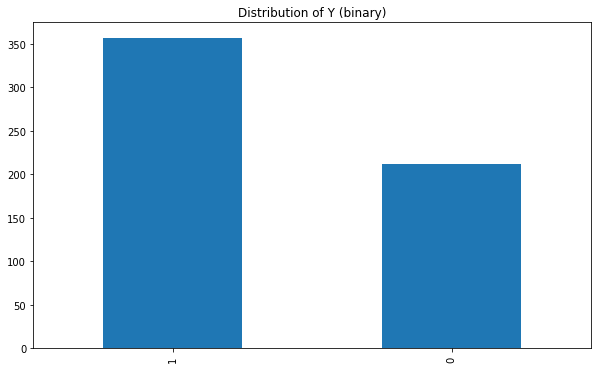

In [6]:
# Distribution of target (Y)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
counts = cancer['target'].value_counts()
counts.plot.bar(ax=ax)
ax.set_title('Distribution of Y (binary)')
plt.show(fig)

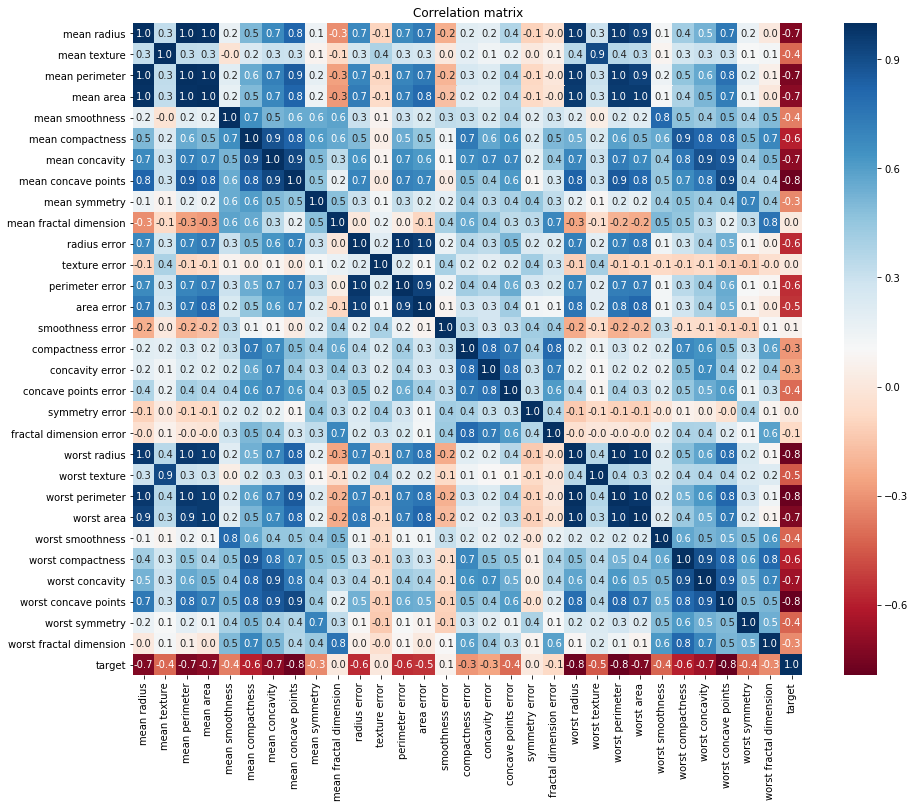

In [7]:
# Check correlation among features
corr_matrix = cancer.corr()
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
sns.heatmap(data=corr_matrix, cmap=plt.cm.RdBu, annot=True, fmt='.1f', ax=ax)
ax.set_title('Correlation matrix')
plt.show(fig)

# Prepare Training & Test Data

In [0]:
# pandas dataframe -> numpy array
X = cancer.drop('target', axis=1).values
y = cancer['target'].values

# Change dtype
X = X.astype(np.float32)
y = y.astype(np.float32)

In [9]:
# Split train & test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify=y)
print('Training data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Training data shape: (455, 30) (455,)
Test data shape: (114, 30) (114,)


In [10]:
# numpy array -> torch float tensor
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Add new dimension
y_train = y_train.unsqueeze(-1)  # (train size, ) -> (train size, 1)
y_test = y_test.unsqueeze(-1)    # (test size, ) -> (test_size, 1)

print('Input(train):', X_train.size(), X_train.dtype)
print('Target(train):', y_train.size(), y_train.dtype)

Input(train): torch.Size([455, 30]) torch.float32
Target(train): torch.Size([455, 1]) torch.float32


# Build & Train Model
- '__init__' 함수 아래에 필요한 연산들을 인스턴스화하고,
- 'forward' 함수 아래에서 실제 연산들을 수행

In [0]:
# Define Model
class LogisticRegressionModel(nn.Module):
    
    def __init__(self, in_features):
        
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features, 1, bias=True)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        
        logits = self.linear(x)
        probs = self.output(logits)
        
        return probs

In [0]:
# Instantiate model
model = LogisticRegressionModel(X_train.size(1))

# Construct loss criterion & optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [21]:
# Train model
num_updates = 5000
for i in range(num_updates):
    
    model.train()
    optimizer.zero_grad()
    
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    
    loss.backward()
    optimizer.step()
    
    train_loss = loss.item()
    
    num_correct = torch.eq(y_train, y_train_pred.round()).float().sum().item()
    train_acc = num_correct / X_train.shape[0]
        
    if (i + 1) % 500 == 0:
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = criterion(y_test_pred, y_test).item()
            
            num_correct = torch.eq(y_test, y_test_pred.round()).float().sum().item()
            test_acc = num_correct / X_test.shape[0]
            
        print(f'Iteration: {i + 1:>04d} | Training Loss: {train_loss:.4f} | Training Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}')

Iteration: 0500 | Training Loss: 0.3149 | Training Acc: 0.895 | Test Acc: 0.930
Iteration: 1000 | Training Loss: 0.2133 | Training Acc: 0.916 | Test Acc: 0.939
Iteration: 1500 | Training Loss: 0.1534 | Training Acc: 0.938 | Test Acc: 0.947
Iteration: 2000 | Training Loss: 0.1320 | Training Acc: 0.941 | Test Acc: 0.947
Iteration: 2500 | Training Loss: 0.1189 | Training Acc: 0.947 | Test Acc: 0.947
Iteration: 3000 | Training Loss: 0.1090 | Training Acc: 0.952 | Test Acc: 0.939
Iteration: 3500 | Training Loss: 0.1014 | Training Acc: 0.960 | Test Acc: 0.939
Iteration: 4000 | Training Loss: 0.0956 | Training Acc: 0.960 | Test Acc: 0.921
Iteration: 4500 | Training Loss: 0.0911 | Training Acc: 0.960 | Test Acc: 0.921
Iteration: 5000 | Training Loss: 0.0875 | Training Acc: 0.960 | Test Acc: 0.930
